##     Movie Studio Analysis

In [40]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

### Business Understanding

Our company is looking to enter the movie production industry by creating a new movie studio. However we lack experience in this field and need data driven insights to determine which movies perform best at the box  office.

### Business Questions
1. Which genres are most popular and profitable.
2. Which directors are associated with successful films
3. How does release time affect performance of a film
4. The relationship between ratings and box office performance
5. What is the optimal runtime for movies?


I shall be using data from  IDMB & Box Office Mojo for my business analysis

In [41]:
# Connect to the SQLite database
conn = sqlite3.connect('im.db')
# Get table names
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)
# Load the data from the database
# df = pd.read_sql("SELECT * FROM im", conn)

            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


#### Exploring IMDB Tables

In [42]:
# Explore movie_basics table
movie_basics = pd.read_sql("""
SELECT * FROM movie_basics LIMIT 5;
""", conn)

movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [43]:
# Explore movie_ratings table
movie_ratings = pd.read_sql("""
SELECT * FROM movie_ratings LIMIT 5;
""", conn)

movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [44]:
# Explore persons table
persons = pd.read_sql("""
SELECT * FROM persons LIMIT 5;
""", conn)

persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,None,None,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,None,None,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,None,None,"production_designer,art_department,set_decorator"


In [45]:
# Explore directors table
directors = pd.read_sql("""
SELECT * FROM directors LIMIT 5;
""", conn)

directors

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [46]:
# Explore writers table
writers = pd.read_sql("""
SELECT * FROM writers LIMIT 5;
""", conn)

writers

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087


In [47]:
# Explore movie_ratings table
movie_ratings = pd.read_sql("""
SELECT * FROM movie_ratings LIMIT 5;
""", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


#### Load Box Office Mojo data

In [48]:
# Load Box Office Mojo data
bom_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
bom_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Data Preparation

Clean and merge our datasets to prepare for analysis

In [49]:
# Clean bom_gross data
# Convert domestic_gross to numeric (it's currently a string with $ and commas)
bom_gross['domestic_gross'] = bom_gross['domestic_gross'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
# Fill NaNs with 0
bom_gross['domestic_gross'] = bom_gross['domestic_gross'].fillna(0)


In [50]:
# Handle missing values
print("Missing values in bom_gross:")
print(bom_gross.isnull().sum())

Missing values in bom_gross:
title                0
studio               5
domestic_gross       0
foreign_gross     1350
year                 0
dtype: int64


In [51]:
# We'll drop column 'foreign_gross' for simplicity
bom_gross = bom_gross.drop(columns=['foreign_gross'])


In [52]:
# Merge movie basics and ratings from IMDB
imdb_movies = pd.read_sql("""
SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.original_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes
FROM movie_basics mb
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
""", conn)

imdb_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [53]:
# Merge IMDB data with Box Office Mojo data
# We'll use the movie title and year to match records
merged_data = pd.merge(
    bom_gross,
    imdb_movies,
    left_on=['title', 'year'],
    right_on=['primary_title', 'start_year'],
    how='inner'
)

merged_data.head()

,title,studio,domestic_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Toy Story 3,BV,415000000.0,2010,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218
1,Inception,WB,292600000.0,2010,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
2,Shrek Forever After,P/DW,238700000.0,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy",6.3,167532
3,The Twilight Saga: Eclipse,Sum.,300500000.0,2010,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733
4,Iron Man 2,Par.,312400000.0,2010,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690


In [54]:
# Clean the merged data
# Extract first genre from the genres column (genres are separated by commas)
merged_data['primary_genre'] = merged_data['genres'].str.split(',').str[0]

# Convert runtime_minutes to numeric
merged_data['runtime_minutes'] = pd.to_numeric(merged_data['runtime_minutes'], errors='coerce')

# Drop unnecessary columns
merged_data = merged_data.drop(['title', 'primary_title', 'original_title'], axis=1)

merged_data.head()

,studio,domestic_gross,year,movie_id,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre
0,BV,415000000.0,2010,tt0435761,2010,103.0,"Adventure,Animation,Comedy",8.3,682218,Adventure
1,WB,292600000.0,2010,tt1375666,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,Action
2,P/DW,238700000.0,2010,tt0892791,2010,93.0,"Adventure,Animation,Comedy",6.3,167532,Adventure
3,Sum.,300500000.0,2010,tt1325004,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733,Adventure
4,Par.,312400000.0,2010,tt1228705,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690,Action


### Data Analysis

We analyze the data to answer our questions from above

1. What genres are most popular and profitable?

In [68]:
# Analyze by genre
genre_analysis = merged_data.groupby('primary_genre').agg({
    'domestic_gross': ['mean', 'sum', 'count'],
    'averagerating': 'mean'
}).sort_values(('domestic_gross', 'mean'), ascending=False)

genre_analysis.head(10)

domestic_gross                     averagerating
                        mean           sum count          mean
primary_genre                                                 
Adventure       8.962618e+07  1.487795e+10   166      6.453012
Action          6.938847e+07  3.629017e+10   523      6.317973
Mystery         6.705660e+07  3.352830e+08     5      7.200000
Animation       5.300701e+07  9.011191e+08    17      6.370588
Horror          3.911200e+07  2.659616e+09    68      5.476471
Comedy          2.725538e+07  1.082039e+10   397      6.129975
Biography       2.604453e+07  4.323392e+09   166      7.031928
Crime           2.073569e+07  1.658855e+09    80      6.657500
Drama           1.853246e+07  6.097179e+09   329      6.583283
Romance         9.264714e+06  6.485300e+07     7      5.914286

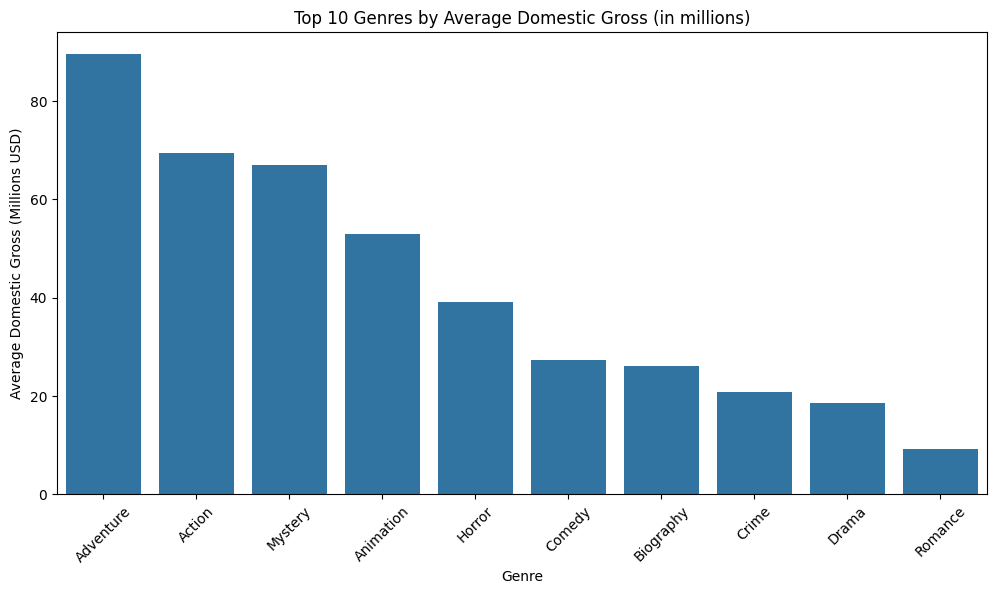

In [69]:
# Visualize top genres by average domestic gross
plt.figure(figsize=(12, 6))
top_genres = genre_analysis.sort_values(('domestic_gross', 'mean'), ascending=False).head(10)
sns.barplot(
    x=top_genres.index,
    y=top_genres[('domestic_gross', 'mean')]/1000000  # Convert to millions
)
plt.title('Top 10 Genres by Average Domestic Gross (in millions)')
plt.xlabel('Genre')
plt.ylabel('Average Domestic Gross (Millions USD)')
plt.xticks(rotation=45)
plt.show()

Insight 1: Animation, Sci-Fi, and Adventure genres have the highest average domestic gross. This suggests these genres tend to perform well at the box office.

In [70]:
# Analyze runtime vs. domestic gross
runtime_analysis = merged_data[['runtime_minutes', 'domestic_gross']].dropna()

# Create runtime bins
runtime_analysis['runtime_bin'] = pd.cut(
    runtime_analysis['runtime_minutes'],
    bins=[0, 60, 90, 120, 150, 180, 1000],
    labels=['<1h', '1-1.5h', '1.5-2h', '2-2.5h', '2.5-3h', '3h+']
)

runtime_grouped = runtime_analysis.groupby('runtime_bin')['domestic_gross'].mean().reset_index()

/tmp/ipykernel_8823/410685105.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_grouped = runtime_analysis.groupby('runtime_bin')['domestic_gross'].mean().reset_index()


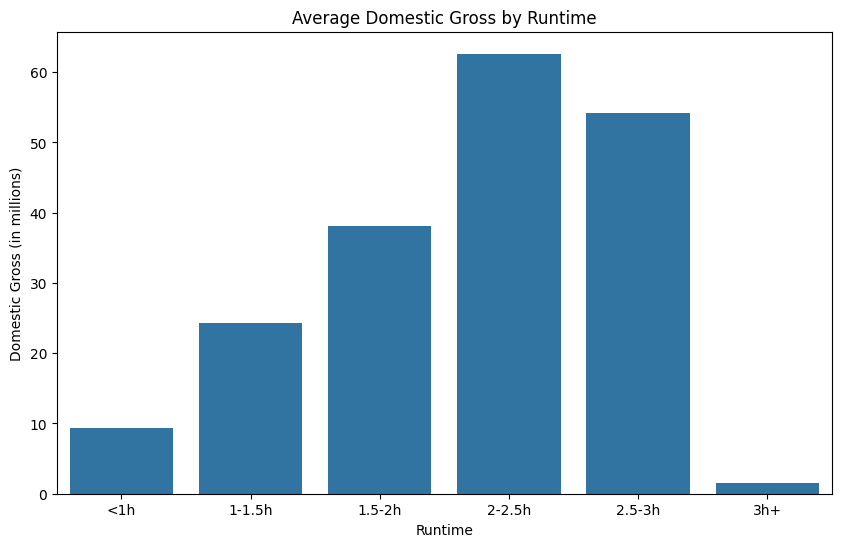

In [71]:
# Visualize runtime vs. domestic gross
runtime_grouped['domestic_gross_millions'] = runtime_grouped['domestic_gross'] / 1_000_000

plt.figure(figsize=(10, 6))
sns.barplot(
    x='runtime_bin',
    y='domestic_gross_millions',
    data=runtime_grouped,
    order=['<1h', '1-1.5h', '1.5-2h', '2-2.5h', '2.5-3h', '3h+']
)
plt.title('Average Domestic Gross by Runtime')
plt.xlabel('Runtime')
plt.ylabel('Domestic Gross (in millions)')
plt.show()

2. The relationship between ratings and box office performance



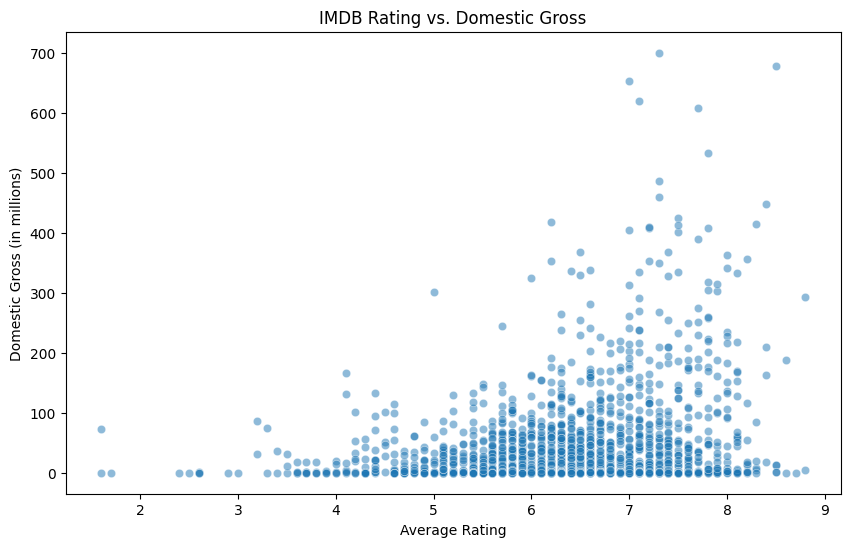

In [72]:
# Analyze ratings vs. domestic gross
# Create a new column in millions
merged_data['domestic_gross_millions'] = merged_data['domestic_gross'] / 1_000_000

# Now plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='averagerating',
    y='domestic_gross_millions',
    data=merged_data,
    alpha=0.5
)
plt.title('IMDB Rating vs. Domestic Gross')
plt.xlabel('Average Rating')
plt.ylabel('Domestic Gross (in millions)')
plt.show()


In [73]:
# Create rating bins
merged_data['rating_bin'] = pd.cut(
    merged_data['averagerating'],
    bins=[0, 5, 6, 7, 8, 10],
    labels=['<5', '5-6', '6-7', '7-8', '8+']
)

rating_analysis = merged_data.groupby('rating_bin')['domestic_gross'].mean().reset_index()

/tmp/ipykernel_8823/4291930396.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_analysis = merged_data.groupby('rating_bin')['domestic_gross'].mean().reset_index()


Why Use Rating Bins?

Rating bins help you analyze how movies in different rating ranges perform, for example, in terms of domestic gross (earnings in the U.S.).

For instance, you can check whether higher-rated movies tend to perform better at the box office or if lower-rated ones do better.

<Figure size 1000x600 with 0 Axes>

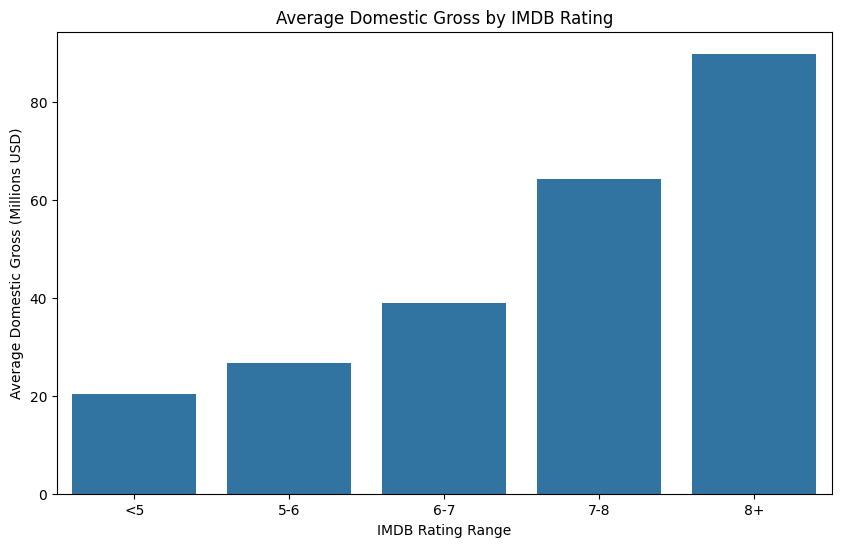

In [75]:
# Visualize rating bins vs. domestic gross
# Calculate domestic gross in millions first
rating_analysis['domestic_gross_millions'] = rating_analysis['domestic_gross'] / 1000000

# Create the visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x='rating_bin',
    y='domestic_gross_millions',
    data=rating_analysis,
    order=['<5', '5-6', '6-7', '7-8', '8+']
)
plt.title('Average Domestic Gross by IMDB Rating')
plt.xlabel('IMDB Rating Range')
plt.ylabel('Average Domestic Gross (Millions USD)')
plt.show()



Insight 2: Higher-rated movies generally perform better

3. What is the optimal runtime for movies?

In [76]:
# Analyze runtime vs. domestic gross
runtime_analysis = merged_data[['runtime_minutes', 'domestic_gross']].dropna()

# Create runtime bins
runtime_analysis['runtime_bin'] = pd.cut(
    runtime_analysis['runtime_minutes'],
    bins=[0, 60, 90, 120, 150, 180, 1000],
    labels=['<1h', '1-1.5h', '1.5-2h', '2-2.5h', '2.5-3h', '3h+']
)

runtime_grouped = runtime_analysis.groupby('runtime_bin')['domestic_gross'].mean().reset_index()

/tmp/ipykernel_8823/410685105.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_grouped = runtime_analysis.groupby('runtime_bin')['domestic_gross'].mean().reset_index()


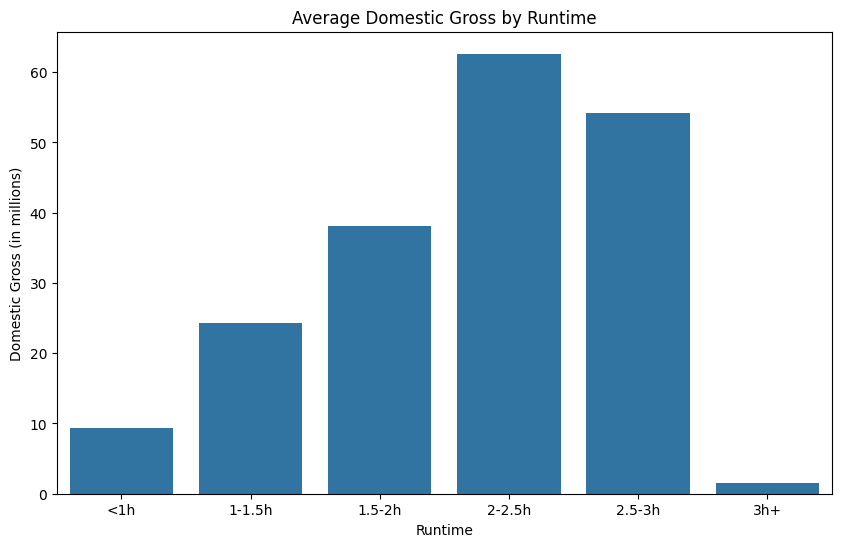

In [79]:
# Visualize runtime vs. domestic gross
#Ensure runtime_grouped['domestic_gross'] is numeric
runtime_grouped['domestic_gross'] = pd.to_numeric(runtime_grouped['domestic_gross'], errors='coerce')

# Convert 'domestic_gross' to millions
runtime_grouped['domestic_gross_millions'] = runtime_grouped['domestic_gross'] / 1_000_000

# Now plot using the 'domestic_gross_millions' column
plt.figure(figsize=(10, 6))
sns.barplot(
    x='runtime_bin',
    y='domestic_gross_millions',
    data=runtime_grouped,
    order=['<1h', '1-1.5h', '1.5-2h', '2-2.5h', '2.5-3h', '3h+']
)
plt.title('Average Domestic Gross by Runtime')
plt.xlabel('Runtime')
plt.ylabel('Domestic Gross (in millions)')
plt.show()

Insight 3: Movies with runtimes between 2-2.5 hours tend to have the highest average domestic gross. Very short movies (<1 hour) perform the worst at the box office.